<a href="https://colab.research.google.com/github/IslamJenishbekov/Analyzing_flat_rents/blob/main/flat_rent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`**Анализ рынка аренды квартир**

В рамках данной проектной работы будут проведены следующие работы:


*   Будут собраны данные с объявлений о аренде квартиры с сайта house.kg. При парсинге они будут записываться в словарь, и в последующем на его основе мы сможем создать наш DataFrame, с которым будем работать. Чтобы каждый раз не парсить сайт, мы запишем наш датасет в .csv файл.

*   Создадим новые колонки в датафрейме для более удобной работы с данными:
1.   *Колонка "rooms_num_square" будет разделена отдельно на колонки "rooms_num" и "square" с преобразованием значений в числовой тип.*
2.   *Колонка "price_period" будет разделена отдельно на колонки "price" и "period". "Price" сразу преобразуем в int, а признак "period" станет номинативной. Updated: при работе с "period" пришел к тому, что около у 10% всех квартир неопределено, на какой срок рассчитана цена (за час/сутки/месяц). Решил, что надо с помощью теста Мэна Витни проанализировать, не является ли эта выборка "родственной" с выборками час/сутка/месяц. При данном анализе было явлено очень большое количество аутлаеров, и пришлось их чистить с датафрейма. (2)Updated: в процессе исследований выяснилось, что у нас осталось всего 2 квартиры. По причине малочисленности данной выборки, решаю их удалить*
3. *Создадим новую колонку "price_day_sq", которая будет показывать стоимость одного квадратного метра в сутки*
3. *Из колонки "address" будет в отдельную колонку "city" вытянута информация по городу.*
4. *Колонка "floors" будет разделена на колонки "flat_floor" и "general_num_floors", которые будут преобразованы в числовой тип. Updated: добавим номинативную колонку, которая будет показывать уровень этажа (level_1, level_2, level_3)*
5. *Колонка "building_type_year" будет разделена на колонки "building_type" и "building_year", который преобразуем в числовой тип. Updated: добавим номинативный признак в какое десятилетие здание было построено (builded_decade)*
6. *Колонка "added_ago" будет приведена к общему формату, и преобразована в "added_ago_days" с значениями в числовом типе. Будут указывать на то, сколько дней назад была опубликовано объявление.*

*   Проанализируем лайки и просмотры:
1.   *Посмотрим медианы "likes" и "views" при группировке по: "type_offer", "period", "rooms_num", "furniture", "series", "condition"*
2.   *Постараемся выявить корреляцию между количеством лайков и просмотров с ценой, площадью жилого помещения. Будут отдельно рассмотрены квартиры по сроку аренды.*

*   Проанализируем ценообразование:
1.   *Посмотрим насколько выгодно/невыгодно брать квартиру в аренду на сутки/месяц сравнении друг другом.*
2.   *Посмотрим на медианы цен, при группировке по: "type_offer", "series", "rooms_num", "furniture", "condition"*
3.  *Посмотрим на корреляцию цены с площадью*
4.  *Постараемся написать функцию, которая будет высчитывать ориентировочную стоимость аренды квартиры пользователя в сутки/месяц
(стоимость в час считать не станем, так как в нашем датасете слишком мало инфо по ним, так как у нас всего 4 квартиры, которые сдаются на час). Стоимость будет рассчитываться на основе: "rooms_num", "square", "city", "type_offer", "furniture", "series", "building_year", "building_type".*















In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, ttest_ind, kruskal
from bs4 import BeautifulSoup
import requests
from google.colab import files, drive

In [ ]:
#Прочитать таблицу
drive.mount("/content/drive")
df = pd.read_csv("flats_rent.csv") #актуально на 11.02.2024

Mounted at /content/drive


##**Парсинг данных**

---



In [ ]:
link_base = "https://www.house.kg/snyat?page="

Все данные буду записывать в этот словарь

In [ ]:
columns=["rooms_num_square", "type_offer", "price_period",
         "views", "likes", "address",
         "apartment_complex", "floors", "furniture",
         "series", "building_type_year", "added_ago",
         "condition", "link"]
data={i:[] for i in columns}
data

{'rooms_num_square': [],
 'type_offer': [],
 'price_period': [],
 'views': [],
 'likes': [],
 'address': [],
 'apartment_complex': [],
 'floors': [],
 'furniture': [],
 'series': [],
 'building_type_year': [],
 'added_ago': [],
 'condition': [],
 'link': []}

In [ ]:
for i in range(1, 382):#382
  link = link_base+str(i)
  page_req = requests.get(link)
  page_soup = BeautifulSoup(page_req.text, "html.parser")
  page_table = page_soup.find("div", attrs={"class":"listings-wrapper"})
  flats = page_table.find_all("div", attrs={"itemtype":"https://schema.org/Apartment", "class":"listing"})
  for flat in flats:
    flat_data = {i : None for i in columns}
    flat_link = "https://www.house.kg"+flat.find("a")["href"]
    flat_data["link"] = flat_link
    flat_req = requests.get(flat_link)
    flat_soup = BeautifulSoup(flat_req.text, "html.parser")

    header = flat_soup.find("div", attrs={"class":"details-header"})
    description = flat_soup.find("div", attrs={"class":"details-main"}).find("div", attrs={"class":"left"})


    rooms_num_square = header.find("h1")
    if rooms_num_square != None:
      flat_data["rooms_num_square"] = rooms_num_square.text.strip()

    address = header.find("div", attrs={"class":"address"})
    if address != None:
      flat_data["address"] = address.text.strip()

    apartment_complex = header.find("div", attrs={"class":"c-name"})
    if apartment_complex != None:
      flat_data["apartment_complex"] = apartment_complex.text.strip()

    price_period = header.find('div', attrs={"class":"price-som"})
    if price_period != None:
      flat_data["price_period"] = price_period.text.strip()

    views = header.find("span", attrs={"class":"view-count"})
    if views != None:
      flat_data["views"] = views.text.strip()

    likes = header.find("span", attrs={"class":"favourite-count table-comments"})
    if likes != None:
      flat_data["likes"] = likes.text.strip()

    added_ago = header.find("span", attrs={"class":"added-span"})
    if added_ago != None:
      flat_data["added_ago"] = added_ago.text.strip()

    type_offer = description.find("div", string="Тип предложения")
    if type_offer != None:
      flat_data["type_offer"] = type_offer.find_next("div", attrs={"class":"info"}).text.strip()

    floors = description.find("div", string="Этаж")
    if floors != None:
      flat_data["floors"] = floors.find_next("div", attrs={"class":"info"}).text.strip()

    furniture = description.find("div", string="Мебель")
    if furniture != None:
      flat_data["furniture"] = furniture.find_next("div", attrs={"class":"info"}).text.strip()

    series = description.find("div", string="Серия")
    if series != None:
      flat_data["series"] = series.find_next("div", attrs={"class":"info"}).text.strip()

    building = description.find("div", string="Дом")
    if building != None:
      flat_data["building_type_year"] = building.find_next("div", attrs={"class":"info"}).text.strip()

    condition = description.find("div", string="Состояние")
    if condition != None:
      flat_data["condition"] = condition.find_next("div", attrs={"class":"info"}).text.strip()

    for column in flat_data:
      data[column].append(flat_data[column])





**На основе словаря с записанными данными
 создаем наш DataFrame**

In [ ]:
df = pd.DataFrame(data)
df.head()

,rooms_num_square,type_offer,price_period,views,likes,address,apartment_complex,floors,furniture,series,building_type_year,added_ago,condition,link
0,"4-комн. кв., 84 м2",от собственника,47 720 сом/мес.,947,8,"Бишкек, Восток-5 м-н, Мамбетова 10/Алматинка",None,2 этаж из 5,частично меблирована,105 серия,панельный,Добавлено 28 дней назад,хорошее,https://www.house.kg/details/885096865a3e4a715...
1,"3-комн. кв., 210 м2",от собственника,216 909 сом/мес.,1175,5,"Бишкек, Бишкек-Парк, Токтогула 163-165/Исанова",Elite Residence,17 этаж из 17,полностью меблирована,элитка,"монолитный, 2018 г.",Добавлено 24 дня назад,евроремонт,https://www.house.kg/details/361640465a8f79574...
2,"3-комн. кв., 70 м2",от собственника,55 000 сом/мес.,561,1,"Бишкек, Сквер Тоголок Молдо",None,1 этаж из 5,полностью меблирована,индивид. планировка,кирпичный,Добавлено 5 дней назад,хорошее,https://www.house.kg/details/624118565c1da7235...
3,"1-комн. кв., 45 м2",от агента,3 500 сом/сутки,3172,3,"Бишкек, Магистраль, Сухэ-Батора/Токомбаева",Итальянский квартал,5 этаж из 8,полностью меблирована,элитка,"монолитный, 2021 г.",Добавлено 5 дней назад,евроремонт,https://www.house.kg/details/707362065c2449528...
4,"1-комн. кв., 49 м2",от агента,3 500 сом/сутки,1237,None,"Бишкек, 5 м-н, Каралаева 38/1/Суеркулова",None,5 этаж из 13,полностью меблирована,элитка,"кирпичный, 2021 г.",Добавлено 9 месяцев назад,евроремонт,https://www.house.kg/details/7792645647422c7df...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rooms_num_square    3168 non-null   object 
 1   type_offer          3168 non-null   object 
 2   price_period        3168 non-null   object 
 3   views               3168 non-null   int64  
 4   likes               1697 non-null   float64
 5   address             3168 non-null   object 
 6   apartment_complex   1179 non-null   object 
 7   floors              3168 non-null   object 
 8   furniture           1824 non-null   object 
 9   series              3168 non-null   object 
 10  building_type_year  3168 non-null   object 
 11  added_ago           3168 non-null   object 
 12  condition           2780 non-null   object 
 13  link                3168 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 346.6+ KB


Сохраняем данные в csv таблицу

In [ ]:
df.to_csv('flats_rent.csv', encoding = 'utf-8-sig', index=False)

## **Общий обзор данных**

In [ ]:
df.head()

,rooms_num_square,type_offer,price_period,views,likes,address,apartment_complex,floors,furniture,series,building_type_year,added_ago,condition,link
0,"4-комн. кв., 84 м2",от собственника,47 720 сом/мес.,947,8.0,"Бишкек, Восток-5 м-н, Мамбетова 10/Алматинка",NaN,2 этаж из 5,частично меблирована,105 серия,панельный,Добавлено 28 дней назад,хорошее,https://www.house.kg/details/885096865a3e4a715...
1,"3-комн. кв., 210 м2",от собственника,216 909 сом/мес.,1175,5.0,"Бишкек, Бишкек-Парк, Токтогула 163-165/Исанова",Elite Residence,17 этаж из 17,полностью меблирована,элитка,"монолитный, 2018 г.",Добавлено 24 дня назад,евроремонт,https://www.house.kg/details/361640465a8f79574...
2,"3-комн. кв., 70 м2",от собственника,55 000 сом/мес.,561,1.0,"Бишкек, Сквер Тоголок Молдо",NaN,1 этаж из 5,полностью меблирована,индивид. планировка,кирпичный,Добавлено 5 дней назад,хорошее,https://www.house.kg/details/624118565c1da7235...
3,"1-комн. кв., 45 м2",от агента,3 500 сом/сутки,3172,3.0,"Бишкек, Магистраль, Сухэ-Батора/Токомбаева",Итальянский квартал,5 этаж из 8,полностью меблирована,элитка,"монолитный, 2021 г.",Добавлено 5 дней назад,евроремонт,https://www.house.kg/details/707362065c2449528...
4,"1-комн. кв., 49 м2",от агента,3 500 сом/сутки,1237,NaN,"Бишкек, 5 м-н, Каралаева 38/1/Суеркулова",NaN,5 этаж из 13,полностью меблирована,элитка,"кирпичный, 2021 г.",Добавлено 9 месяцев назад,евроремонт,https://www.house.kg/details/7792645647422c7df...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rooms_num_square    3168 non-null   object 
 1   type_offer          3168 non-null   object 
 2   price_period        3168 non-null   object 
 3   views               3168 non-null   int64  
 4   likes               1697 non-null   float64
 5   address             3168 non-null   object 
 6   apartment_complex   1179 non-null   object 
 7   floors              3168 non-null   object 
 8   furniture           1824 non-null   object 
 9   series              3168 non-null   object 
 10  building_type_year  3168 non-null   object 
 11  added_ago           3168 non-null   object 
 12  condition           2780 non-null   object 
 13  link                3168 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 346.6+ KB


Можно посмотреть уникальные значения в некоторых колонках

In [ ]:
print(df.type_offer.unique())
print(len(df.apartment_complex.unique()))
print(df.furniture.unique())
print(len(df.series.unique()))
print(df.condition.unique())

['от собственника' 'от агента']
235
['частично меблирована' 'полностью меблирована' nan 'пустая']
15
['хорошее' 'евроремонт' 'среднее' nan 'под самоотделку (псо)']


## **Работа с колонками**

##rooms_num_square

In [ ]:
df.rooms_num_square.map(lambda i: int(i[0]) if i[0].isdigit() else i.split(",")[0]).unique()

array([4, 3, 1, 2, 6, 5, 'свободная планировка кв.'], dtype=object)

In [ ]:
df["rooms_num"] = df.rooms_num_square.map(lambda i: int(i[0]) if i[0].isdigit() else None)

In [ ]:
df.rooms_num_square.map(lambda i: i.split(",")[1].split()[0].strip()).unique()

array(['84', '210', '70', '45', '49', '97', '54', '65', '100', '104',
       '90', '89', '85', '55', '78', '80', '58', '120', '150', '83', '40',
       '35', '33', '42', '36', '75', '95', '44', '76', '68', '69', '60',
       '119', '59', '50', '200', '53', '88', '226', '105', '122', '28',
       '72', '38', '32', '56', '102', '176.25', '34', '62', '127', '64',
       '30', '73', '51', '110', '250', '106', '140', '160', '115', '43',
       '220', '74', '130', '190', '135', '94', '63', '79', '165', '158',
       '117', '145', '116', '86', '52', '125', '146', '87', '41', '47',
       '77', '275', '37', '103', '170', '175', '188', '67', '66', '176',
       '209', '230', '260', '98', '108', '96', '237', '380', '182', '147',
       '137', '48', '124', '111', '264', '61', '164', '300', '138', '92',
       '57', '82', '113', '71', '93', '91', '109', '185', '223', '132',
       '184', '222', '48.18', '112', '155', '114', '154', '310', '128',
       '126', '187', '168', '134', '81', '107', '750'

In [ ]:
df["square"] = df.rooms_num_square.map(lambda i: float(i.split(",")[1].split()[0].strip()))


In [ ]:
#было 3168 квартир
print("До чистки")
print("MAX: ", df.square.max())
print("MIN: ", df.square.values.min())
#Вижу явные выбросы, было бы неплохо их почистить
#Чистил по своему усмотрению: 0.005 квантиль и 0.995 квантиль

print("После чистки")
left_border = np.quantile(df.square.values, 0.005)
right_border = np.quantile(df.square.values, 0.995)
print(left_border, right_border)
df = df.loc[(df["square"] > 29.67) & (df["square"] < 280)]
print("Потеря составила 33 квартиры, что примерно 1%")

До чистки
MAX:  3500.0
MIN:  1.0
После чистки
29.67 280.0
Потеря составила 33 квартиры, что примерно 1%


In [ ]:
df.loc[df["rooms_num"].isnull()].link.values

array(['https://www.house.kg/details/3402628653bd8c2dd6206-84428800',
       'https://www.house.kg/details/559964665b3582b92e144-23050292',
       'https://www.house.kg/details/468548065bb2e9a02b218-17855655',
       'https://www.house.kg/details/50052766589440c9a3e49-23883711'],
      dtype=object)

In [ ]:
df.drop("rooms_num_square", axis=1, inplace=True)

<ipython-input-12-0f9a26ce941c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("rooms_num_square", axis=1, inplace=True)


##price_period


In [ ]:
df["price"] = df.price_period.map(lambda i: int("".join(i.split()[:-1]).replace(" ", "")))

In [ ]:
df["period"] = df.price_period.map(lambda i: i.split()[-1].replace("сом/", ""))

In [ ]:
period_undefined_price = df.loc[df["period"] == "сом", "price"].values
print(period_undefined_price.min())
print(len(period_undefined_price))
# 338 из 3185

27764
338


По моему мнению, учитывая минимальное значение, в этой группе находятся цены за месяц. Проверим гипотезу, используя Т тест и тест Мэна Витни

In [ ]:
df["period"].unique()

array(['мес.', 'сутки', 'сом', 'час'], dtype=object)

In [ ]:
price_month = df.loc[df["period"] == "мес.", "price"].values
price_day = df.loc[df["period"] == "сутки", "price"].values
price_hour = df.loc[df["period"] == "час", "price"].values

<Axes: ylabel='Density'>

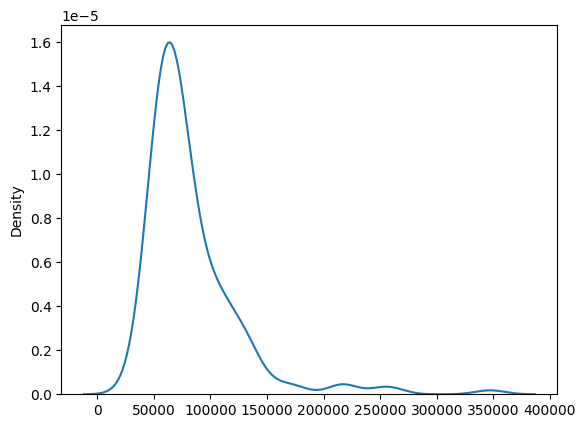

In [ ]:
sns.kdeplot(period_undefined_price)

<Axes: ylabel='Density'>

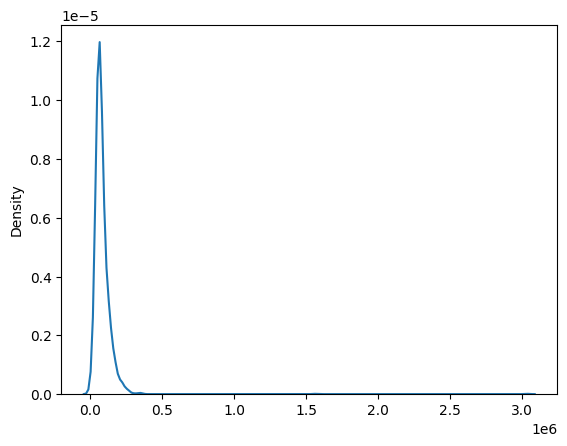

In [ ]:
sns.kdeplot(price_month)

<Axes: ylabel='Density'>

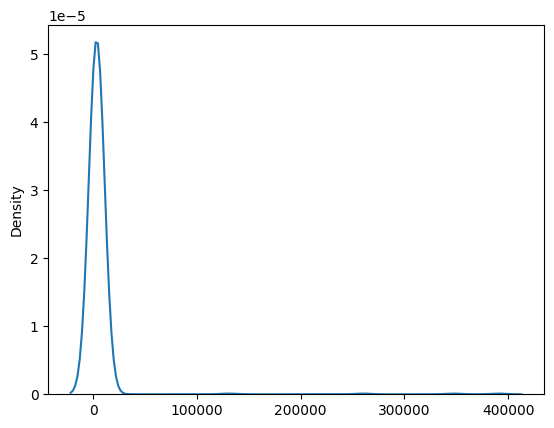

In [ ]:
sns.kdeplot(price_day)

<Axes: ylabel='Density'>

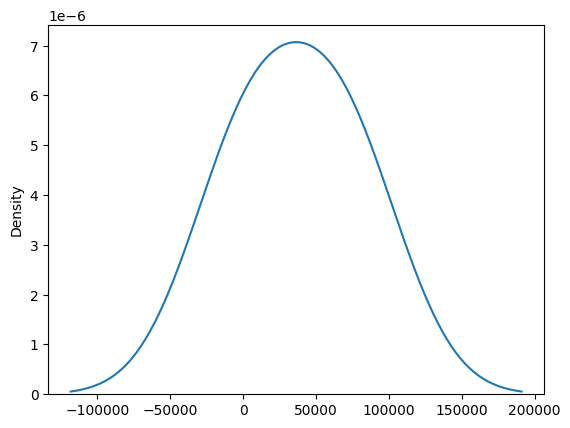

In [ ]:
sns.kdeplot(price_hour)

In [ ]:
print(mannwhitneyu(price_day, period_undefined_price))
print(mannwhitneyu(price_month, period_undefined_price))
#Результат очень сильно удивил. Возможно дело в аутлаерах, буду их чистить

MannwhitneyuResult(statistic=1318.0, pvalue=2.513648235629788e-131)
MannwhitneyuResult(statistic=366059.5, pvalue=0.11535222848630836)


Будем чистить данные по колонке прайс, но сгруппировав их по периоду аренды

In [ ]:
#Функция для определения усов нумпай массива
def define_borders(data: np.ndarray)->list:
  quartile_1 = np.quantile(data, 0.25)
  quartile_2 = np.quantile(data, 0.5)
  quartile_3 = np.quantile(data, 0.75)
  left_border = quartile_1 - 1.5 * (quartile_3 - quartile_1)
  right_border = quartile_3 + 1.5 * (quartile_3 - quartile_1)
  return [left_border, right_border]

In [ ]:
period_undefined_price_borders = define_borders(period_undefined_price)
price_month_borders = define_borders(price_month)
price_day_borders = define_borders(price_day)
price_hour_borders = define_borders(price_hour)
print(price_hour_borders)

[-29455.5, 102366.5]


In [ ]:
print(len(price_hour))
#Осталось всего 2 квартиры, которые сдавались на час. Решил их удалить, так как выводов по ним
#не сделаешь, а мешать они будут

df = df.loc[df["period"] != "час"]
df.period.unique()

2


array(['мес.', 'сутки', 'сом'], dtype=object)

In [ ]:
#Было 319 значений
period_undefined_df = df.loc[df["period"] == "сом"]
period_undefined_df = period_undefined_df.loc[(period_undefined_df["price"] > period_undefined_price_borders[0]) & (period_undefined_df["price"] < period_undefined_price_borders[1])]
period_undefined_df.info()
#Очистилось 2 квартиры

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 180 to 3167
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_offer          317 non-null    object 
 1   price_period        317 non-null    object 
 2   views               317 non-null    int64  
 3   likes               90 non-null     float64
 4   address             317 non-null    object 
 5   apartment_complex   0 non-null      object 
 6   floors              317 non-null    object 
 7   furniture           0 non-null      object 
 8   series              317 non-null    object 
 9   building_type_year  317 non-null    object 
 10  added_ago           317 non-null    object 
 11  condition           0 non-null      object 
 12  link                317 non-null    object 
 13  rooms_num           317 non-null    float64
 14  square              317 non-null    float64
 15  price               317 non-null    int64  
 16  perio

In [ ]:
#было 2173 значений
month_df = df.loc[df["period"] == "мес."]
month_df = month_df.loc[(month_df["price"] > price_month_borders[0]) & (month_df["price"] < price_month_borders[1])]
month_df.info()
#очистилось 18 значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 3166
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_offer          2155 non-null   object 
 1   price_period        2155 non-null   object 
 2   views               2155 non-null   int64  
 3   likes               1132 non-null   float64
 4   address             2155 non-null   object 
 5   apartment_complex   987 non-null    object 
 6   floors              2155 non-null   object 
 7   furniture           1332 non-null   object 
 8   series              2155 non-null   object 
 9   building_type_year  2155 non-null   object 
 10  added_ago           2155 non-null   object 
 11  condition           2153 non-null   object 
 12  link                2155 non-null   object 
 13  rooms_num           2151 non-null   float64
 14  square              2155 non-null   float64
 15  price               2155 non-null   int64  
 16  period

In [ ]:
#было 482 значений
day_df = df.loc[df["period"] == "сутки"]
day_df = day_df.loc[(day_df["price"] > price_day_borders[0]) & (day_df["price"] < price_day_borders[1])]
day_df.info()
#очистилось 1 значение

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 3 to 3162
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_offer          481 non-null    object 
 1   price_period        481 non-null    object 
 2   views               481 non-null    int64  
 3   likes               385 non-null    float64
 4   address             481 non-null    object 
 5   apartment_complex   100 non-null    object 
 6   floors              481 non-null    object 
 7   furniture           348 non-null    object 
 8   series              481 non-null    object 
 9   building_type_year  481 non-null    object 
 10  added_ago           481 non-null    object 
 11  condition           434 non-null    object 
 12  link                481 non-null    object 
 13  rooms_num           481 non-null    float64
 14  square              481 non-null    float64
 15  price               481 non-null    int64  
 16  period 

In [ ]:
df = pd.concat([period_undefined_df, month_df, day_df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953 entries, 180 to 3162
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_offer          2953 non-null   object 
 1   price_period        2953 non-null   object 
 2   views               2953 non-null   int64  
 3   likes               1607 non-null   float64
 4   address             2953 non-null   object 
 5   apartment_complex   1087 non-null   object 
 6   floors              2953 non-null   object 
 7   furniture           1680 non-null   object 
 8   series              2953 non-null   object 
 9   building_type_year  2953 non-null   object 
 10  added_ago           2953 non-null   object 
 11  condition           2587 non-null   object 
 12  link                2953 non-null   object 
 13  rooms_num           2949 non-null   float64
 14  square              2953 non-null   float64
 15  price               2953 non-null   int64  
 16  peri

Теперь постараюсь заново сравнить выборку с неопределенным периодом аренды с выборкой, период аренды которых 1 месяц


In [ ]:
price_undefined_period = df.loc[df["period"] == "сом", "price"].values
price_month = df.loc[df["period"] == "мес.", "price"].values
price_day = df.loc[df["period"] == "сутки", "price"].values

MannwhitneyuResult(statistic=0.0, pvalue=9.00790804629466e-128)


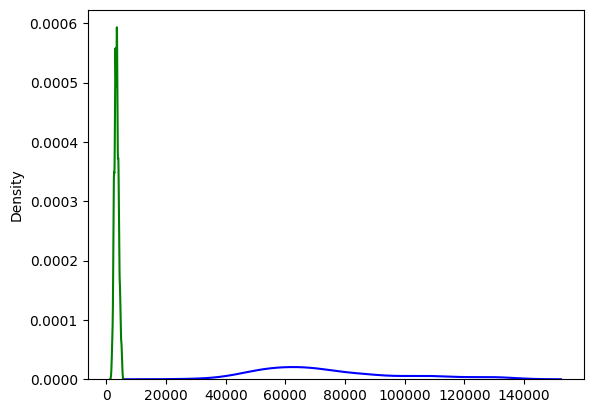

In [ ]:
sns.kdeplot(price_undefined_period, color="blue")
sns.kdeplot(price_day, color="green")
print(mannwhitneyu(price_day, price_undefined_period))

MannwhitneyuResult(statistic=360763.5, pvalue=0.1049695468645935)


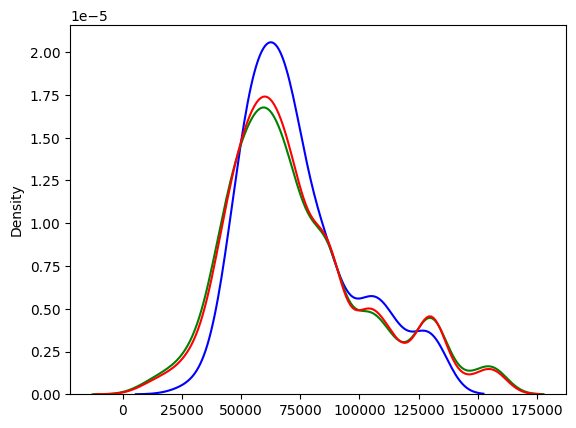

In [ ]:
sns.kdeplot(price_undefined_period, color="blue")
sns.kdeplot(price_month, color="green")
sns.kdeplot(np.concatenate((price_undefined_period, price_month)), color="red")
print(mannwhitneyu(price_undefined_period, price_month))

In [ ]:
#len(price_undefined_period) = 317
#len(price_month) = 2155
#len(price_day) = 481

In [ ]:
#Тест Мана Витни выдает аномальный результат, но отталкиваясь от графика, я предполагаю,
#что в данной выборке в большинстве своем находятся цены за месяц
df.period = df.period.replace({"сом":"месяц", "мес.":"месяц"})

#Updated: тесты работали верно. Просто перепутал условия принятия нулевой гипотезы

In [ ]:
df.drop("price_period", axis=1, inplace=True)

##price_day_sq

In [ ]:
df["price_day_sq"] = df["price"].astype("float64")

In [ ]:
df.loc[df["period"] == "месяц", "price_day_sq"] /= 30

In [ ]:
df["price_day_sq"] /= df["square"]

In [ ]:
df.head()

,type_offer,views,likes,address,apartment_complex,floors,furniture,series,building_type_year,added_ago,condition,link,rooms_num,square,price,period,price_day_sq
180,от агента,24,NaN,"Бишкек, Мед. академия, Абая, 7А",NaN,3 этаж из 12,NaN,индивид. планировка,"монолитный, 2017 г.",Добавлено 2 дня назад,NaN,https://www.house.kg/details/465108065c6bd7702...,2.0,90.0,52058,месяц,19.280741
184,от агента,23,NaN,"Бишкек, Мед. академия, Абая, 58",NaN,6 этаж из 12,NaN,индивид. планировка,"монолитный, 2015 г.",Добавлено 2 дня назад,NaN,https://www.house.kg/details/174520065c6bd5b2e...,3.0,94.0,69411,месяц,24.613830
187,от агента,24,NaN,"Бишкек, Мед. академия, Абая, 58",NaN,6 этаж из 12,NaN,индивид. планировка,"монолитный, 2015 г.",Добавлено 2 дня назад,NaN,https://www.house.kg/details/174520065c6bd5b2e...,3.0,94.0,69411,месяц,24.613830
191,от агента,12,NaN,"Бишкек, АУЦА, Токомбаева, 9",NaN,8 этаж из 10,NaN,индивид. планировка,"кирпичный, 2020 г.",Добавлено 3 дня назад,NaN,https://www.house.kg/details/383571465c51b32dc...,2.0,76.0,60735,месяц,26.638158
192,от агента,18,NaN,"Бишкек, Ак Кеме, Чынгыза Айтматова пр-т, 93",NaN,2 этаж из 9,NaN,индивид. планировка,"кирпичный, 2015 г.",Добавлено 3 дня назад,NaN,https://www.house.kg/details/519776865c51b18e8...,3.0,130.0,95440,месяц,24.471795


##address

In [ ]:
df.address.map(lambda i: i.split(",")[0]).unique()

array(['Бишкек', 'с. Кок-Джар', 'с. Сары-Ой', 'Кант',
       'Иссык-Кульская область', 'с. Чон-Сары-Ой', 'с. Карагай-Булак',
       'Ош', 'Ошская область'], dtype=object)

In [ ]:
df["city"] = df.address.map(lambda i: i.split(",")[0])

## floors

In [ ]:
df["flat_floor"] = df.floors.map(lambda i: int(i.split()[0]))
df["general_num_floors"] = df.floors.map(lambda i: int(i.split()[-1]))

In [ ]:
df["floor_level"] = df.flat_floor / df.general_num_floors
values = [0, 0.33, 0.66, 1]
floor_levels = ["level_1", "level_2", "level_3"]

df.floor_level = pd.cut(df.floor_level.values, values, labels=floor_levels)

In [ ]:
df.drop("floors", axis=1, inplace=True)

##building_type_year

In [ ]:
df["building_type"] = df.building_type_year.map(lambda i: i.split(",")[0])
df["building_type"].unique()

array(['монолитный', 'кирпичный', 'панельный'], dtype=object)

In [ ]:
df["building_year"] = df.building_type_year.map(lambda i: None if "," not in i else i.split()[1])
df.building_year = df.building_year.map(lambda i: "19"+i if i!=None and len(i)==2 else i).astype("float64")
df.building_year.unique()

array([2017., 2015., 2020., 1991., 2018., 2021., 2011., 2022., 2019.,
       2023., 1975., 1973., 2013., 1992., 1986., 2014., 2016., 2007.,
       2009., 2005., 2012., 1989., 1985., 1981., 1988., 2010., 1980.,
       2024., 1996., 2004., 1972., 1977., 1956., 1990., 2000., 1978.,
       1983., 2008., 1982., 2006.,   nan, 1962., 1971., 1993., 1968.,
       1997., 1964., 1966., 1999., 1987., 1965., 1970., 1998., 1960.,
       1974., 1995., 1967.])

In [ ]:
decade_labels = [str(i)+"s" for i in range(1960, 2031, 10)]
values = [i for i in range(1950, 2031, 10)]
df["building_decade"] = pd.cut(df.building_year, labels=decade_labels, bins=values)
df.building_decade.unique()

['2020s', '2000s', '2030s', '1980s', '1990s', '2010s', '1960s', NaN, '1970s']
Categories (8, object): ['1960s' < '1970s' < '1980s' < '1990s' < '2000s' < '2010s' < '2020s' < '2030s']

In [ ]:
df.drop("building_type_year", axis=1, inplace=True)

##added_ago

In [ ]:
#функия будет уточнять сколько дней висит объявление
def define_prescription(added_ago: str)->str:
  added_ago_splited = added_ago.split()
  if added_ago_splited[2].startswith("д"):
    return added_ago_splited[1]
  elif added_ago_splited[2].startswith("ч"):
    return "1"
  elif added_ago_splited[2].startswith("м"):
    return str(int(added_ago_splited[1])*30)
  else:
    return str(int(added_ago_splited[1])*360)

In [ ]:
df["added_ago_days"] = df.added_ago.map(lambda i: define_prescription(i)).astype(int)
df.added_ago_days.unique()

array([   2,    3,    9,   10,   11,   12,   13,   16,   17,   18,   19,
         20,   21,   23,   24,   25,   26,   27,   28,   30,   60,   90,
        120,  150,  180,  210,  240,  270,  300,  360,    5,    8,   22,
          1,    6,    7,   29,  330,  720,    4,   15,   14, 1440, 1080])

In [ ]:
df.drop("added_ago", axis=1, inplace=True)

## likes

In [ ]:
df.fillna(value={"likes":0}, inplace=True)

## **Анализ количества просмотров и лайков**

In [ ]:
print(np.median(df.views.values), np.median(df.likes.values))
df_month = df.loc[df["period"] == "месяц"] # 2472
df_day = df.loc[df["period"] == "сутки"] # 481
print(np.median(df_day.views.values), np.median(df_day.likes.values))
print(np.median(df_month.views.values), np.median(df_month.likes.values))

695.0 1.0
2794.0 3.0
620.0 0.0


##Посмотрим на медианы просмотров и лайков при различных значений некоторых колонок

In [ ]:
df.groupby("type_offer").agg({"views" : "median",
                              "likes" : "median",
                              "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
type_offer,,,
от собственника,806.5,1.0,762
от агента,670.0,0.0,2191


In [ ]:
df.groupby(["period", "type_offer"]).agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

views  likes  count
period type_offer                           
сутки  от агента        3653.0    3.0    268
       от собственника  1618.0    2.0    213
месяц  от собственника   662.0    1.0    549
       от агента         607.0    0.0   1923

In [ ]:
df_day.groupby("series").agg({"views" : "median",
                          "likes" : "median",
                          "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
series,,,
106 серия улучшенная,7673.0,12.0,6
106 серия,5926.0,8.5,4
сталинка,5638.5,9.5,6
104 серия улучшенная,5323.0,3.0,8
элитка,2948.0,3.0,397
104 серия,2292.0,2.0,9
индивид. планировка,2237.5,6.5,24
105 серия,2045.0,4.0,15
108 серия,1328.0,2.0,1


In [ ]:
df_month.groupby("series").agg({"views" : "median",
                          "likes" : "median",
                          "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
series,,,
хрущевка,1333.0,3.0,9
104 серия улучшенная,1017.0,4.0,4
107 серия,915.5,0.0,2
106 серия,788.0,1.0,65
пентхаус,785.5,1.5,6
105 серия,709.5,0.0,60
108 серия,660.5,1.0,16
элитка,647.0,1.0,1744
104 серия,635.0,1.0,63


In [ ]:
df_day.groupby("rooms_num").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
rooms_num,,,
1.0,3288.5,3.0,240
2.0,2518.0,2.0,222
3.0,1746.0,2.0,18
4.0,627.0,7.0,1


In [ ]:
df_month.groupby("rooms_num").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
rooms_num,,,
6.0,2344.0,15.0,1
1.0,710.0,1.0,339
4.0,651.0,0.0,187
2.0,628.0,1.0,1217
3.0,570.0,0.0,711
5.0,425.0,1.0,13


In [ ]:
df_day.groupby("furniture").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
furniture,,,
полностью меблирована,2948.0,3.0,343
частично меблирована,1285.0,4.0,5


In [ ]:
df_month.groupby("furniture").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
furniture,,,
полностью меблирована,678.0,1.0,1277
частично меблирована,610.0,1.0,51
пустая,570.5,0.5,4


In [ ]:
df_day.groupby("condition").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
condition,,,
под самоотделку (псо),2781.0,0.0,3
хорошее,2258.0,4.0,63
евроремонт,2153.0,2.0,365
среднее,1105.0,2.0,3


In [ ]:
df_month.groupby("condition").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
condition,,,
под самоотделку (псо),1017.0,3.0,1
среднее,763.0,1.0,19
хорошее,674.0,1.0,387
евроремонт,649.0,1.0,1746


In [ ]:
df.groupby("period").agg({"views" : "median",
                             "likes" : "median",
                             "price" : "count"}).sort_values("views", ascending=False).rename(columns={"price":"count"})

,views,likes,count
period,,,
сутки,2794.0,3.0,481
месяц,620.0,0.0,2472




Среднее количество просмотров и лайков по всей выборке составляет 695 и 1. При анализе оказалось, что выборка квартир, которые сдаются на сутки и на месяц, отличаются между собой, и из за того что в общей выборке количество квартир на месяц и на сутки идут примерно 5 к 1, то правильней будет анализировать их отдельно.

1) При сдаче на сутки (481 объявление):
- в среднем получают 2794 просмотра и 3 лайка на каждом объявлении
- популярностью пользуются предложения от агентов, набирают на 2035 просмотров больше, но при этом всего на 1 лайк больше
- в основном это полностью меблированные элитки с евроремонтом
- наблюдается обратная корреляция с числом комнат

2) При сдаче на месяц (2472 объявлений):
- в среднем 620 просмотров и 0 лайков
- в срденем набирают на 55 просмотров и на 1 лайк больше предложения от собственников
- опять же больше полностью меблированных квартир, но стоит учитывать, что в этой колонке очень много нулов
- квартир с хорошим состоянием в 5 раз меньше, чем квартир с евроремонтом, но в среднем они набрали на 25 просмотров больше

Немного удивлен, что квартиры, которые на сдаются на сутки просматривают чаще, учитывая, крепкие родственные связи у основной части населения.
Но возможно это связано с тем, что таких квартир меньше почти в 5 раз. Допустим, пользователь зашел на сайт, поставил фильтр поиска по периоду аренды: месяц или сутки. Просмотрел 10 квартир и вышел. В таком случае, в меньшей выборке, в конечном счете среднее значение просмотров должно быть больше. В нашем случае это примерно в 5 раз (реальное значение составляет 4.5)

Пользователь при поиске квартиры на один день может и не придавать столь большого значения разнице в цене в предложении от агента и от собственника (подробней о разнице в ценах расмотрим в подглаве "Сравнение стоимости аренды квартир, которые сдаются на месяц и на день"). И могу предположить, что при сдаче квартиру на сутки, визуальная составляющая и описание в объявлении более важно, чтобы заинтересовать клиента, а в этом я думаю, что агент справится лучше собственника.

Как и ожидалось больше клиенты ищут именно маленькие квартиры на день. А вот при сдаче на месяц, лидером по количеству просмотров в среднем оказались однокомнатные, опережают на 60 просмотров следующие за ним 4-комнатные. Такой результат, по моему мнению, наталкивает на мысль, что примерно в той же пропорции проживают в съемных квартирах, как и молодые люди, одни, так и пары без детей, которые могут жить и в однушке, а также и многодетные семьи, которым требуется больше комнат. Но не исключаю, что просто в многодетных семьях, родители более придирчивы к квартире и просто просматривают больше вариантов, чтобы подобрать наиболее подходящий, а молодые люди просто берут количеством.


## Есть ли корреляция количества просмотров и лайков с ценой и площадью квартиры

In [ ]:
flats_day = df.loc[df["period"] == "сутки"]
flats_month = df.loc[df["period"] == "месяц"]

Квартиры, которые сдаются на сутки

PearsonRResult(statistic=-0.1294069249784648, pvalue=0.004473416281139854)

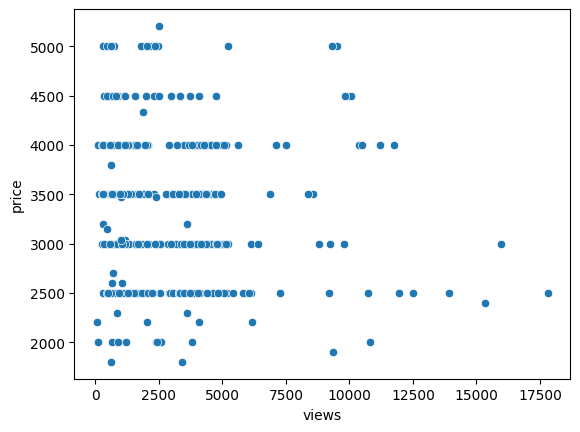

In [ ]:
sns.scatterplot(flats_day, x = "views", y = "price")
pearsonr(flats_day.views.values, flats_day.price.values)

PearsonRResult(statistic=-0.2239310417573985, pvalue=6.992986489628287e-07)

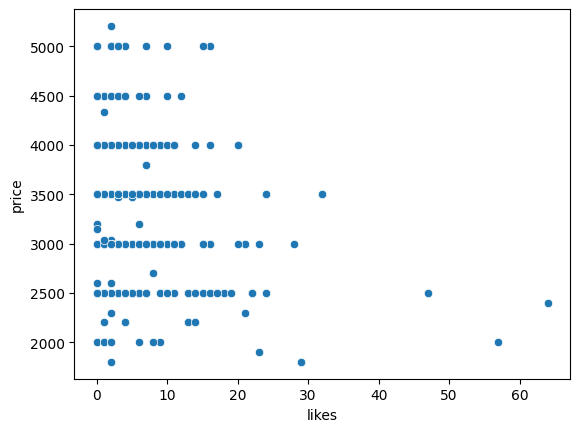

In [ ]:
sns.scatterplot(flats_day, x = "likes", y = "price")
pearsonr(flats_day.likes.values, flats_day.price.values)

PearsonRResult(statistic=-0.23189993246034243, pvalue=2.703808818386168e-07)

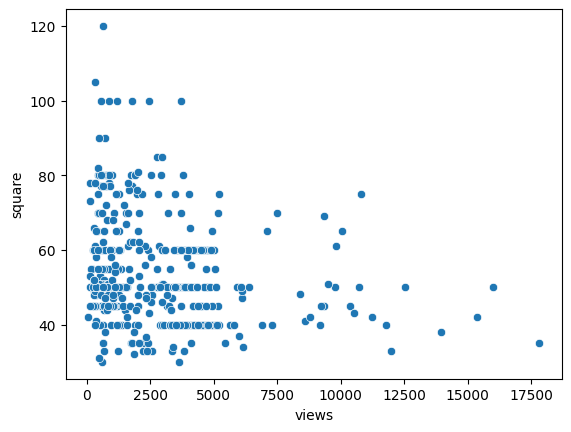

In [ ]:
sns.scatterplot(flats_day, x = "views", y = "square")
pearsonr(flats_day.views.values, flats_day.square.values)

PearsonRResult(statistic=-0.19651666541384794, pvalue=1.4174866877237098e-05)

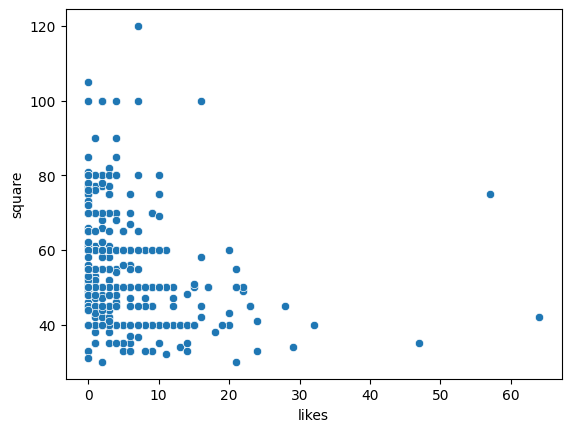

In [ ]:
sns.scatterplot(flats_day, x = "likes", y = "square")
pearsonr(flats_day.likes.values, flats_day.square.values)

PearsonRResult(statistic=0.1478348321845322, pvalue=0.001147091891480928)

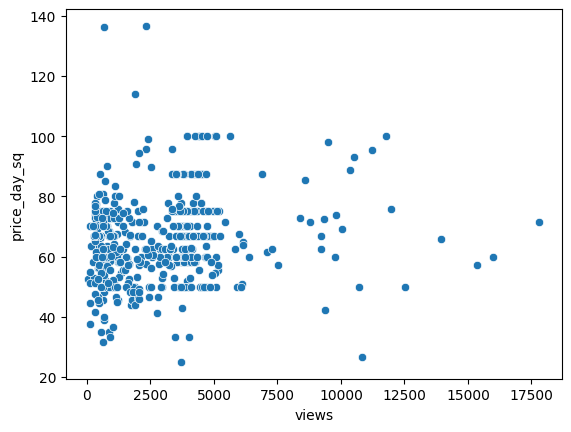

In [ ]:
sns.scatterplot(flats_day, x = "views", y = "price_day_sq")
pearsonr(flats_day.views.values, flats_day.price_day_sq.values)

PearsonRResult(statistic=0.04789465623295392, pvalue=0.29450941173329814)

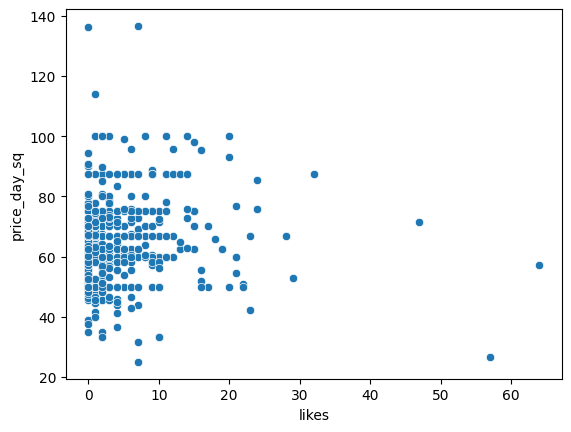

In [ ]:
sns.scatterplot(flats_day, x = "likes", y = "price_day_sq")
pearsonr(flats_day.likes.values, flats_day.price_day_sq.values)

Квартиры, которые сдаются на месяц

PearsonRResult(statistic=-0.05781727444564232, pvalue=0.0040328472592344)

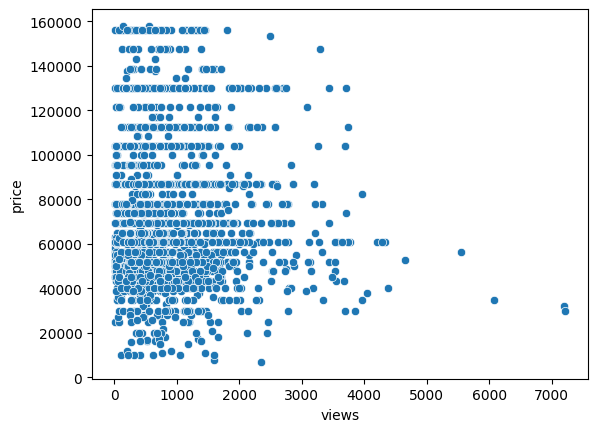

In [ ]:
sns.scatterplot(flats_month, x = "views", y = "price")
pearsonr(flats_month.views.values, flats_month.price.values)

PearsonRResult(statistic=-0.1977011204481537, pvalue=3.317828761618213e-23)

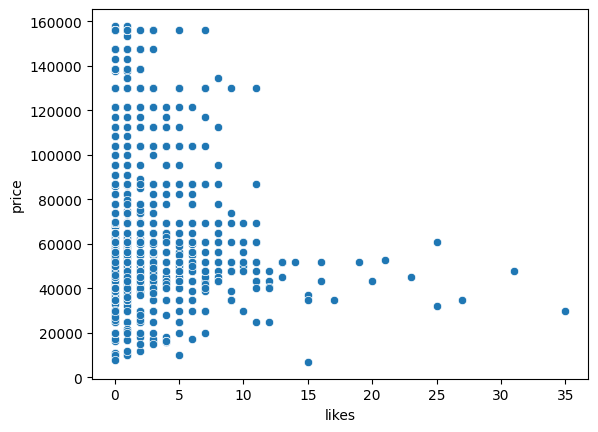

In [ ]:
sns.scatterplot(flats_month, x = "likes", y = "price")
pearsonr(flats_month.likes.values, flats_month.price.values)

PearsonRResult(statistic=-0.04409836769672137, pvalue=0.028343878317737065)

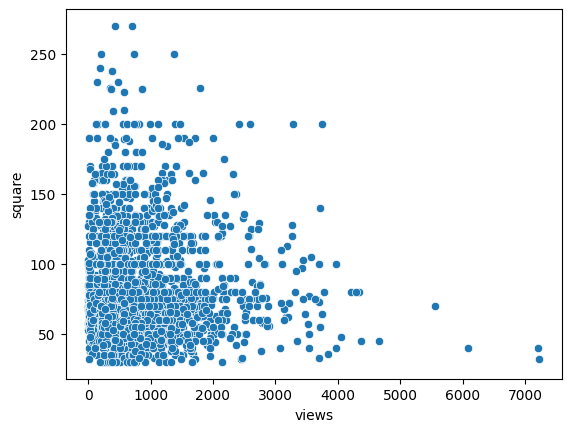

In [ ]:
sns.scatterplot(flats_month, x = "views", y = "square")
pearsonr(flats_month.views.values, flats_month.square.values)

PearsonRResult(statistic=-0.15629823123578257, pvalue=5.488886359676646e-15)

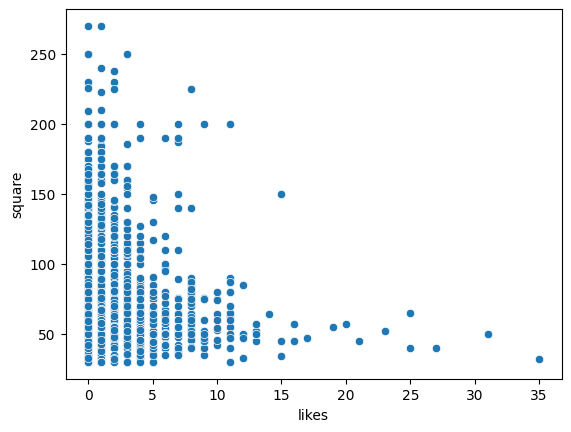

In [ ]:
sns.scatterplot(flats_month, x = "likes", y = "square")
pearsonr(flats_month.likes.values, flats_month.square.values)

PearsonRResult(statistic=-0.01900852240479258, pvalue=0.34481405562301376)

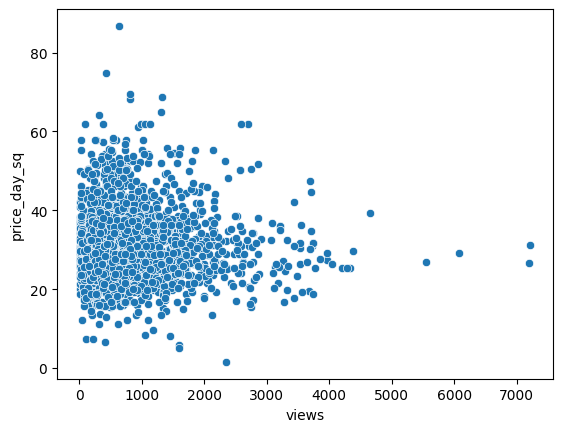

In [ ]:
sns.scatterplot(flats_month, x = "views", y = "price_day_sq")
pearsonr(flats_month.views.values, flats_month.price_day_sq.values)

PearsonRResult(statistic=-0.05175602983567645, pvalue=0.010061967837805058)

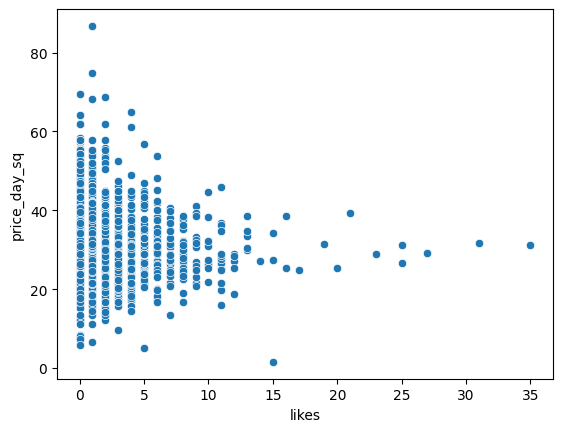

In [ ]:
sns.scatterplot(flats_month, x = "likes", y = "price_day_sq")
pearsonr(flats_month.likes.values, flats_month.price_day_sq.values)

## **Анализ ценообразования**

In [ ]:
flats_day = df.loc[df["period"] == "сутки"] #481
flats_month = df.loc[df["period"] == "месяц"] #2472


## Сравнение стоимости аренды квартир, которые сдаются на месяц и на день

MannwhitneyuResult(statistic=21504.5, pvalue=6.008957953056569e-246)


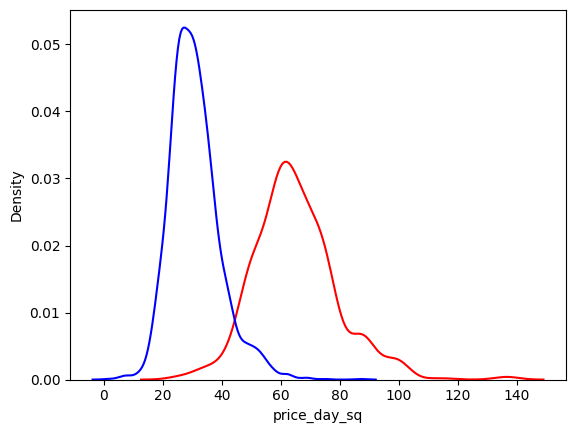

In [ ]:
sns.kdeplot(flats_day, x="price_day_sq", color="red")
sns.kdeplot(flats_month, x="price_day_sq", color="blue")
print(mannwhitneyu(flats_month.price_day_sq.values, flats_day.price_day_sq.values))

In [ ]:
df.groupby("period").agg({"price_day_sq":"mean"})
#print(65.007/30.857) = 2.106718086657809
#print(np.median(df.square.values)) = 70

,price_day_sq
period,
месяц,30.857525
сутки,65.007445


In [ ]:
df.groupby("period").agg({"price_day_sq":"median"})
#print(62.5/29.772) = 2.0992879215370146

,price_day_sq
period,
месяц,29.772059
сутки,62.500000


По графику сразу видно, что стоимость 1 кв.м. в день при сдачи квартиры в аренду на сутки и в месяц отличаются очень сильно, и вероятность получить две такие выборки из одной общей случайно практически равны нулю. В среднем (и по медиане и по среднему арифметическому) переплата составляет 35 рублей, а это уже 210%.

Возьмем среднестатистическую квартиру с площадью 70кв.м. При сдаче ее в аренду на месяц, мы получим 29.77 *70 *30 = 62517 сом. Если мы эту же квартиру будем сдавать посуточно, то, чтобы получить те же деньги, мы должны сдать ее 62517 / 62,5 / 70 = 14 раз, то есть на 14 дней

##Посмотрим на медианы цен при различных значениях некоторых колонок

In [ ]:
flats_day.groupby("type_offer").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)
# 1.785

,price_day_sq,count
type_offer,,
от агента,64.285714,268
от собственника,62.500000,213


In [ ]:
flats_month.groupby("type_offer").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)
# 2.773

,price_day_sq,count
type_offer,,
от агента,30.550704,1923
от собственника,27.777778,549


In [ ]:
flats_day.groupby("series").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
series,,
индивид. планировка,71.428571,24
хрущевка,70.322581,2
106 серия улучшенная,65.248227,6
106 серия,63.571429,4
104 серия улучшенная,63.095238,8
104 серия,62.500000,9
элитка,62.500000,397
сталинка,62.352941,6
105 серия,60.606061,15


In [ ]:
flats_month.groupby("series").agg({"price_day_sq":"mean", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
series,,
108 серия,32.185590,16
элитка,32.024347,1744
сталинка,30.464480,7
индивид. планировка,28.852598,464
хрущевка,28.060533,9
105 серия улучшенная,27.256695,9
104 серия улучшенная,26.883780,4
104 серия,26.865715,63
105 серия,26.252970,60


In [ ]:
flats_day.groupby("condition").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
condition,,
евроремонт,66.666667,365
под самоотделку (псо),63.636364,3
хорошее,60.606061,63
среднее,50.000000,3


In [ ]:
flats_month.groupby("condition").agg({"price_day_sq":"mean", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
condition,,
под самоотделку (псо),32.134815,1
евроремонт,32.002221,1746
хорошее,26.434911,387
среднее,23.451713,19


In [ ]:
flats_day.groupby("furniture").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
furniture,,
полностью меблирована,65.789474,343
частично меблирована,62.500000,5


In [ ]:
flats_month.groupby("furniture").agg({"price_day_sq":"mean", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
furniture,,
полностью меблирована,31.290407,1277
пустая,25.213898,4
частично меблирована,24.872623,51


In [ ]:
flats_day.groupby("rooms_num").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
rooms_num,,
1.0,66.666667,240
2.0,60.000000,222
3.0,54.595588,18
4.0,31.666667,1


In [ ]:
flats_month.groupby("rooms_num").agg({"price_day_sq":"mean", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
rooms_num,,
2.0,32.517096,1217
1.0,31.644621,339
3.0,28.784227,711
4.0,27.256561,187
5.0,21.900559,13
6.0,1.555556,1


In [ ]:
flats_day.groupby("flat_floor").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
flat_floor,,
13,77.777778,3
1,66.666667,29
3,66.666667,57
7,64.057751,52
10,63.821138,28
15,63.636364,1
9,62.678571,24
2,62.500000,52
4,62.500000,65


In [ ]:
flats_month.groupby("flat_floor").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
flat_floor,,
18,54.649632,2
24,40.044615,1
17,37.184286,5
12,37.078632,76
15,36.691045,5
22,36.151667,1
11,33.907586,87
16,32.777333,9
13,32.374378,43


In [ ]:
flats_day.groupby("general_num_floors").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
general_num_floors,,
8,75.000000,5
18,71.428571,1
5,69.368132,32
2,67.481884,10
11,66.666667,22
19,66.666667,1
7,66.666667,56
13,66.666667,17
3,64.705882,7


In [ ]:
flats_month.groupby("general_num_floors").agg({"price_day_sq":"median", "views":"count"}).rename(columns={"views":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
general_num_floors,,
22,53.163971,4
23,47.325455,1
19,46.997083,27
24,37.397989,1
25,36.151528,4
8,34.877089,58
17,33.774953,52
15,33.597956,72
14,33.370513,163


In [ ]:
flats_day.groupby("floor_level").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
floor_level,,
level_2,63.636364,254
level_3,62.678571,158
level_1,62.500000,69


In [ ]:
flats_month.groupby("floor_level").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
floor_level,,
level_1,30.241542,436
level_2,30.000000,953
level_3,28.921429,1083


In [ ]:
flats_day.groupby("building_decade").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
building_decade,,
2000s,66.666667,8
2030s,66.666667,26
1980s,62.500000,3
1990s,61.011905,10
2010s,60.984848,10
1970s,60.000000,3
2020s,58.578431,64
1960s,55.000000,2


In [ ]:
flats_month.groupby("building_decade").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
building_decade,,
2030s,33.370513,301
1960s,33.052857,2
2020s,30.986905,995
2000s,28.349603,24
1990s,25.945534,32
1970s,25.862069,12
1980s,24.789524,27
2010s,24.200225,32


In [ ]:
flats_day.groupby("city").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
city,,
с. Сары-Ой,136.612022,1
Иссык-Кульская область,95.744681,10
Ошская область,72.780459,6
Ош,64.144737,4
Бишкек,62.500000,460


In [ ]:
flats_month.groupby("city").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
city,,
Бишкек,29.918391,2432
с. Чон-Сары-Ой,26.511111,1
Иссык-Кульская область,23.498333,17
с. Кок-Джар,23.305589,18
с. Сары-Ой,21.761830,2
с. Карагай-Булак,21.212121,1
Кант,19.841270,1


In [ ]:
flats_day.groupby("building_type").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
building_type,,
кирпичный,66.666667,340
панельный,60.303030,24
монолитный,58.823529,117


In [ ]:
flats_month.groupby("building_type").agg({"price_day_sq":"median", "period":"count"}).rename(columns={"period":"count"}).sort_values("price_day_sq", ascending=False)

,price_day_sq,count
building_type,,
монолитный,31.436232,1405
кирпичный,27.988172,892
панельный,26.785714,175


в среднем при аренде квартиры на сутки:

- если брать квартиру у агента, а не у собственника,то клиент переплачивает на 1.785 сом за каждый кв.м. в день. При средней площади квартир в 70кв.м., переплата составляет 1.785 * 70 = 124.95 сом
- на примере зависимости цены квадратного метра от количества комнат особенно хорошо такое явление, что первые квадратные метры самые дорогие, т.е. чем квартира больше, тем дешевле обойдется каждый квадратный метр

в среднем при аренде квартиры на месяц:
- если брать квартиру у агента, а не у собственника, то клиента переплачивает 2.773 сом за каждый кв.м. в день. При средней площади квартир в 70 кв.м., переплата составляет 2.773 * 70 * 30 = 5823.3 сом в месяц
- квадратный метр в двухкомнатных квартирах обходится дороже чем в однокомнатных, а далее наблюдаем ту же картину, что чем больше комнат в квартире, тем дешевле каждый квадратный метр
- цена за кв.м. в день дороже на нихних этажах
- в высотках цены дороже

##furniture

In [ ]:
day_furniture_nan = flats_day[flats_day["furniture"].isna()]
day_furniture_full = flats_day[flats_day["furniture"] == "полностью меблирована"]

MannwhitneyuResult(statistic=20717.0, pvalue=0.11976218360735172)

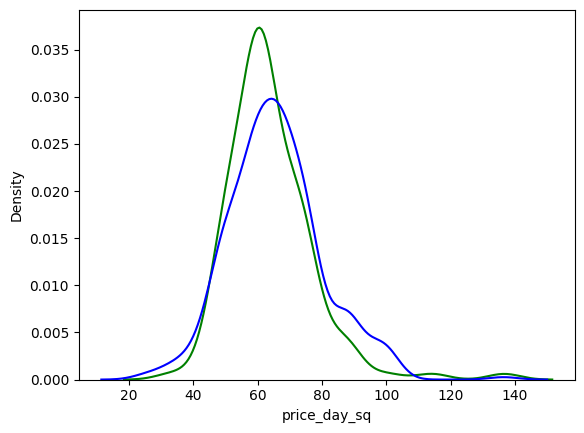

In [ ]:
sns.kdeplot(day_furniture_nan, x = "price_day_sq", color="green")
sns.kdeplot(day_furniture_full, x = "price_day_sq", color="blue")
mannwhitneyu(day_furniture_nan.price_day_sq.values, day_furniture_full.price_day_sq.values)

In [ ]:
month_furniture_nan = flats_month[flats_month["furniture"].isna()] #1140
month_furniture_full = flats_month[flats_month["furniture"] == "полностью меблирована"] #1277
month_furniture_partially = flats_month[flats_month["furniture"] == "частично меблирована"] #51
month_furniture_partially.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 3045
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   type_offer          51 non-null     object  
 1   views               51 non-null     int64   
 2   likes               51 non-null     float64 
 3   address             51 non-null     object  
 4   apartment_complex   15 non-null     object  
 5   furniture           51 non-null     object  
 6   series              51 non-null     object  
 7   condition           51 non-null     object  
 8   link                51 non-null     object  
 9   rooms_num           51 non-null     float64 
 10  square              51 non-null     float64 
 11  price               51 non-null     int64   
 12  period              51 non-null     object  
 13  price_day_sq        51 non-null     float64 
 14  city                51 non-null     object  
 15  flat_floor          51 non-null     int6

MannwhitneyuResult(statistic=706859.0, pvalue=0.21947350334530347)
MannwhitneyuResult(statistic=41866.5, pvalue=1.0109424660507483e-07)


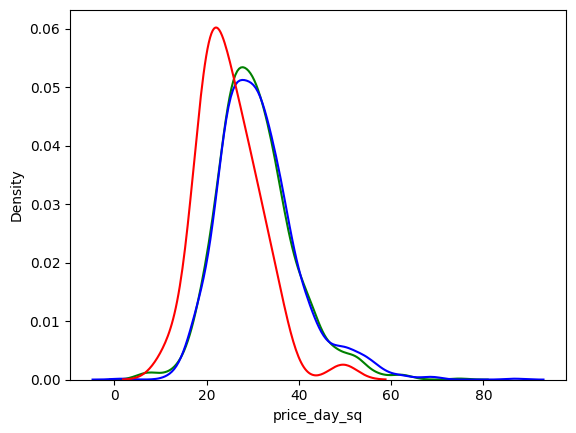

In [ ]:
sns.kdeplot(month_furniture_nan, x = "price_day_sq", color="green")
sns.kdeplot(month_furniture_full, x = "price_day_sq", color="blue")
print(mannwhitneyu(month_furniture_nan.price_day_sq.values, month_furniture_full.price_day_sq.values))
sns.kdeplot(month_furniture_partially, x = "price_day_sq", color="red")
print(mannwhitneyu(month_furniture_nan.price_day_sq.values, month_furniture_partially.price_day_sq.values))

In [ ]:
print(np.median(day_furniture_nan.views.values))
print(np.median(day_furniture_full.views.values))
mannwhitneyu(day_furniture_full.views.values, day_furniture_nan.views.values)

2538.0
2948.0


MannwhitneyuResult(statistic=25682.5, pvalue=0.03291344609619974)

In [ ]:
print(np.median(month_furniture_nan.views.values))
print(np.median(month_furniture_full.views.values))
mannwhitneyu(month_furniture_nan.views.values, month_furniture_full.views.values)

563.0
678.0


MannwhitneyuResult(statistic=619397.0, pvalue=2.3806102329721724e-10)

In [ ]:
day_furniture_nan.groupby("type_offer").agg({"price_day_sq":"count"})

,price_day_sq
type_offer,
от агента,90
от собственника,43


In [ ]:
month_furniture_nan.groupby("type_offer").agg({"price_day_sq":"count"})

,price_day_sq
type_offer,
от агента,1023
от собственника,117


По графикам и тесту Манна Уитни видим, что квартиры в которых не прописана есть ли там мебель или нет, лежат в той же ценовой категории, что и полностью меблированные. И это наводит на следующие размышления:
- люди просто не обращают на это внимание, и забывают это указать. В таком случае они получают в среднем на 20% меньше просмотров при сдаче квартиру на месяц, и на 16% меньше при сдаче в сутки. Учитывая то, что большинство таких квартир сдают агенты, мне это кажется немного нелогичным
- чтобы не испугать клиента они специально пропускают это поле, и ставят такую же цену, если бы квартира полностью меблированной
- квартиры, где указана мебель, являются пустыми, либо частично меблированными, но имеют определенный плюс, который отсутсвует у полностью меблированных квартир, и эти факторы балансируются между собой
- понятие "частичный" - обширное понятие, и может ввести в заблуждение потенциального покупателя, поэтому его не любят использовать

## Корреляция цены и площади

PearsonRResult(statistic=0.534379526797106, pvalue=7.178770596620795e-37)

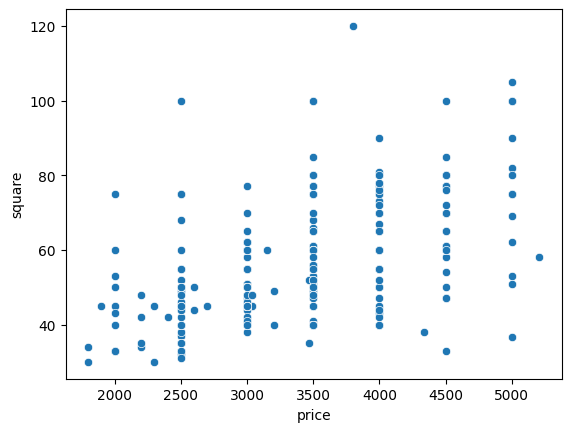

In [ ]:
sns.scatterplot(flats_day, x="price", y="square")
pearsonr(flats_day.price.values, flats_day.square.values)

PearsonRResult(statistic=0.534379526797106, pvalue=7.178770596620795e-37)

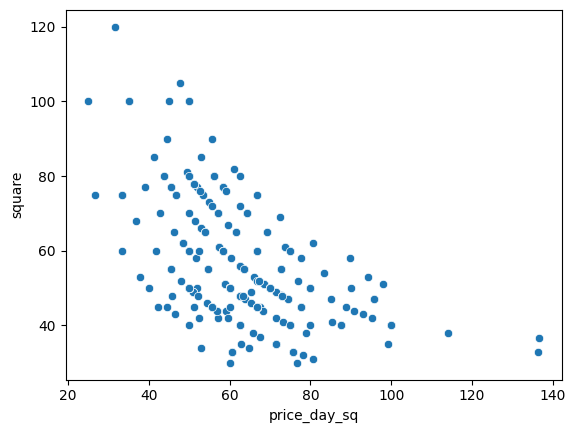

In [ ]:
sns.scatterplot(flats_day, x="price_day_sq", y="square")
pearsonr(flats_day.price.values, flats_day.square.values)

PearsonRResult(statistic=0.7480689276389918, pvalue=0.0)

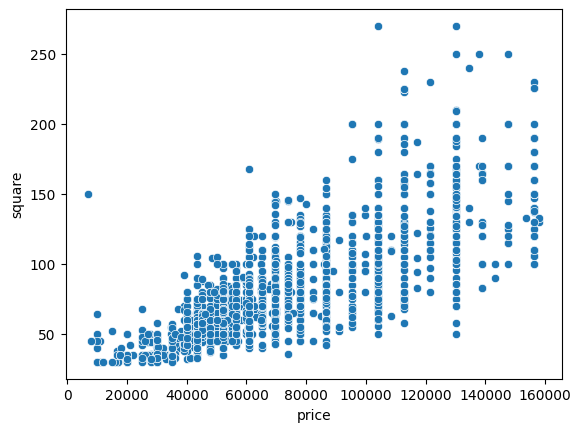

In [ ]:
sns.scatterplot(flats_month, x="price", y="square")
pearsonr(flats_month.price.values, flats_month.square.values)

PearsonRResult(statistic=-0.27581152590714947, pvalue=2.1179578325612496e-44)

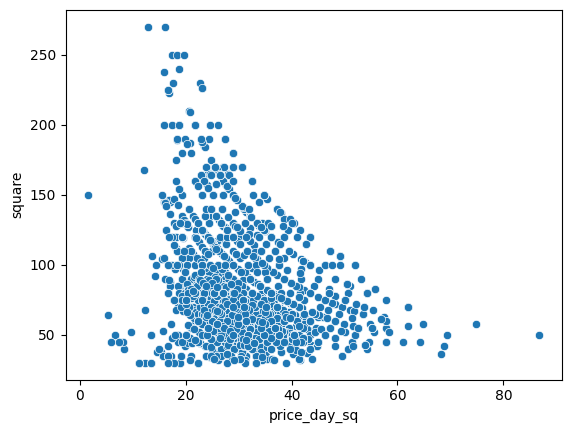

In [ ]:
sns.scatterplot(flats_month, x="price_day_sq", y="square")
pearsonr(flats_month.price_day_sq.values, flats_month.square.values)

## Расчет стоимости аренды квартир по заданным параметрам



In [ ]:
help_df = df[["type_offer",
              "period",
              "rooms_num",
              "square",
              "condition",
              "flat_floor",
              "general_num_floors",
              "building_type",
              "price"
              ]]
help_df['rooms_num'] = help_df['rooms_num'].fillna(help_df['rooms_num'].mean())
help_df = help_df.loc[df["condition"].isna() == False]
help_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3162
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_offer          2587 non-null   object 
 1   period              2587 non-null   object 
 2   rooms_num           2587 non-null   float64
 3   square              2587 non-null   float64
 4   condition           2587 non-null   object 
 5   flat_floor          2587 non-null   int64  
 6   general_num_floors  2587 non-null   int64  
 7   building_type       2587 non-null   object 
 8   price               2587 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 202.1+ KB


<ipython-input-116-4d6793aad62c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  help_df['rooms_num'] = help_df['rooms_num'].fillna(help_df['rooms_num'].mean())


In [ ]:
def prepare_df(column_name: str):
  unique_vals = help_df[column_name].unique()
  for i in unique_vals:
    help_df[i] = help_df[column_name].map(lambda j: 1 if j == i else 0)
  help_df.drop(column_name, axis=1, inplace=True)
prepare_df("type_offer")
prepare_df("period")
prepare_df("condition")
prepare_df("building_type")

In [ ]:
prices = help_df.price.values
features = help_df.drop("price", axis=1).values
weights = np.linalg.lstsq(features, prices)[0]

<ipython-input-118-c81811db7b4a>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights = np.linalg.lstsq(features, prices)[0]


In [ ]:
sum_mistakes = 0
for i in range(2587):
  sum_mistakes += abs(prices[i] - np.dot(weights, features[i])) / prices[i]
print(sum_mistakes)
print(sum_mistakes/2587)
# формула считает с погрешностью в 68%

1769.8684695978345
0.6841393388472495


In [ ]:
help_df.head()

,rooms_num,square,flat_floor,general_num_floors,price,от собственника,от агента,месяц,сутки,хорошее,евроремонт,среднее,под самоотделку (псо),панельный,кирпичный,монолитный
0,4.0,84.0,2,5,47720,1,0,1,0,1,0,0,0,1,0,0
2,3.0,70.0,1,5,55000,1,0,1,0,1,0,0,0,0,1,0
5,2.0,97.0,4,6,52058,1,0,1,0,0,1,0,0,0,1,0
7,2.0,54.0,9,9,45000,1,0,1,0,0,1,0,0,1,0,0
9,2.0,100.0,8,10,69411,0,1,1,0,0,1,0,0,0,0,1


По 8 параметрам я постарался получить "веса" для расчета стоимости квартиры пользователя. Для решения системы уравнений из 2587 уравнений с 8 неизвестными я использовал np.linalg.lstsq(). Матрицу с весами я получил, но при ее проверке на тех же данных оказалось, что средняя арифметическая данной ошибки составляет около 68%, что на мой взгляд является ошибкой очень большой.

## Попытка №2
Разделю квартиры которые сдаются на сутки отдельно от квартир, которые сдаются на месяц

In [ ]:
help_df = df[["type_offer",
              "period",
              "rooms_num",
              "square",
              "condition",
              "flat_floor",
              "general_num_floors",
              "building_type",
              "price"
              ]]
help_df['rooms_num'] = help_df['rooms_num'].fillna(help_df['rooms_num'].mean())
help_df = help_df.loc[df["condition"].isna() == False]
df_month = help_df.loc[help_df["period"] == 'месяц'].drop("period", axis=1)
df_day = help_df.loc[help_df["period"] == "сутки"].drop("period", axis=1)

<ipython-input-130-2f7d69c74307>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  help_df['rooms_num'] = help_df['rooms_num'].fillna(help_df['rooms_num'].mean())


In [ ]:
def prepare_df(column_name: str):
  unique_vals = df_month[column_name].unique()
  for i in unique_vals:
    df_month[i] = df_month[column_name].map(lambda j: 1 if j == i else 0)
    df_day[i] = df_day[column_name].map(lambda j: 1 if j == i else 0)
  df_month.drop(column_name, axis=1, inplace=True)
  df_day.drop(column_name, axis=1, inplace=True)
prepare_df("type_offer")
prepare_df("condition")
prepare_df("building_type")

In [ ]:
df_day.head()

,rooms_num,square,flat_floor,general_num_floors,price,от собственника,от агента,хорошее,евроремонт,среднее,под самоотделку (псо),панельный,кирпичный,монолитный
3,1.0,45.0,5,8,3500,0,1,0,1,0,0,0,0,1
4,1.0,49.0,5,13,3500,0,1,0,1,0,0,0,1,0
6,2.0,70.0,5,12,4500,1,0,0,1,0,0,0,0,1
8,2.0,65.0,9,11,4500,1,0,0,1,0,0,1,0,0
26,1.0,40.0,4,9,2500,1,0,0,1,0,0,0,1,0


In [ ]:
prices_day = df_day.price.values
features_day = df_day.drop("price", axis=1).values
weights_day = np.linalg.lstsq(features_day, prices_day)[0]
sum_mistakes = 0
for i in range(434):
  sum_mistakes += abs(prices_day[i] - np.dot(weights_day, features_day[i])) / prices_day[i]
print(sum_mistakes/434)

0.1151218471872257


<ipython-input-137-076ac8678044>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights_day = np.linalg.lstsq(features_day, prices_day)[0]


In [ ]:
prices_month = df_month.price.values
features_month = df_month.drop("price", axis=1).values
weights_month = np.linalg.lstsq(features_month, prices_month)[0]
sum_mistakes = 0
for i in range(2153):
  sum_mistakes += abs(prices_month[i] - np.dot(weights_month, features_month[i])) / prices_month[i]
print(sum_mistakes/2153)

0.20138084215687493


<ipython-input-140-30d52057853c>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights_month = np.linalg.lstsq(features_month, prices_month)[0]


Результат удивил! На тех же данных, теперь веса определяют цену квартиру, которая сдается на день с точность 11%, а цену квартиру на месяц с точностью 20% в среднем

##info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953 entries, 180 to 3162
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   type_offer          2953 non-null   object  
 1   views               2953 non-null   int64   
 2   likes               2953 non-null   float64 
 3   address             2953 non-null   object  
 4   apartment_complex   1087 non-null   object  
 5   furniture           1680 non-null   object  
 6   series              2953 non-null   object  
 7   condition           2587 non-null   object  
 8   link                2953 non-null   object  
 9   rooms_num           2949 non-null   float64 
 10  square              2953 non-null   float64 
 11  price               2953 non-null   int64   
 12  period              2953 non-null   object  
 13  price_day_sq        2953 non-null   float64 
 14  city                2953 non-null   object  
 15  flat_floor          2953 non-null   

In [ ]:
df.link.values

array(['https://www.house.kg/details/885096865a3e4a7157cc3-03300933',
       'https://www.house.kg/details/361640465a8f7957403d4-72594610',
       'https://www.house.kg/details/624118565c1da72354084-86405374', ...,
       'https://www.house.kg/details/5766798657fec353320f0-62930719',
       'https://www.house.kg/details/4313209656ec8d2122383-50429513',
       'https://www.house.kg/details/4752857656fbf9acbe451-02334655'],
      dtype=object)